In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

gpu_device = 1

num_classes = 4
class_sliding = 3
class_not_sliding = 1

net_in_dims = 3
net_in_channels = 1
net_channels=(32, 64, 128)
net_strides=(2, 2)
        
num_folds = 15

num_slices = 48
size_x = 320
size_y = 320
roi_size = (size_x,size_y,num_slices)

num_workers_te = 0
batch_size_te = 1

model_filename_base = "./results/BAMC_PTX_ARUNet-3D-NRS"

model_type = "best" # "best" or "last"

In [3]:
num_images = len(all_images)
print(num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62 62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


In [4]:
# Keep this line to init ITK readers
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        #SpatialCropd(
            #roi_start=[0,0,1],
            #roi_end=[320,320,61],
            #keys=["image", "label"]),
        #Lambdad(
            #func=lambda x: np.where(x==3,1,x),
            #keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

tensor(2.)
Data Size = torch.Size([1, 1, 320, 320, 48])


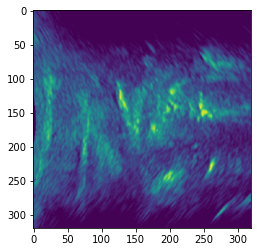

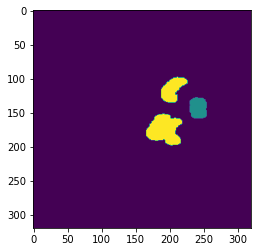

In [6]:
imgnum = 0
batchnum = 0
channelnum = 0
slicenum = 24

img = utils.first(test_loader[batchnum])["image"]
print("Image shape =", img.shape)
print("Label range =", img[imgnum,channelnum,:,:,slicenum].min(), img[imgnum,channelnum,:,:,slicenum].max())
lbl = utils.first(test_loader[batchnum])["label"]
print("Label shape =", lbl.shape)
print("Label range =", lbl[imgnum,channelnum,:,:,slicenum].min(), lbl[imgnum,0,:,:,slicenum].max())

plt.figure("Testing", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[channelnum, :, :, slicenum], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(lbl[channelnum, :, :, slicenum])
plt.show()

In [7]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:"+str(gpu_device))

In [8]:
def plot_vfold_training_curves(vfold_num, test_loader, min_size_comp, max_size_comp, sliding_prior, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    patient_correct = 0
    patient_incorrect = 0
    patient_false_negatives = 0
    
    frame_correct = 0
    frame_incorrect = 0    
    frame_false_negatives = 0
    
    roi_correct = 0
    roi_incorrect = 0
    roi_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
    
        metric_file = model_filename_base+"_val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'.'+model_type+'_model.vfold_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dims,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            fold_imgnum = 0
            fname = os.path.basename(test_files[vfold_num][fold_imgnum]["image"])
            prevfname = fname
            frame_roi_count = 0
            frame_roi_count_not_sliding = 0
            patient_frame_count = 0
            patient_frame_count_not_sliding = 0
            for batchnum,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for batch_imgnum in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][fold_imgnum]["image"])
                    
                    if fname[:22]!=prevfname[:22]:
                        patient_frame_count += 1
                        if frame_roi_count_not_sliding == 0: # frame_roi_count
                            if graph:
                                print(" ** Frame Winner = Sliding ( NS =",frame_roi_count_not_sliding,"of",frame_roi_count,")")
                            if prevfname[3] == 's':
                                frame_correct += 1
                                if graph:
                                    print("    Correct")
                            else:
                                frame_incorrect += 1
                                frame_false_negatives += 1
                                print("    Frame False Negative =", prevfname)
                        else:
                            patient_frame_count_not_sliding += 1
                            if graph:
                                print(" ** Frame Winner = Not Sliding ( NS =",frame_roi_count_not_sliding,"of",frame_roi_count,")")
                            if prevfname[3] == 'n':
                                frame_correct += 1
                                if graph:
                                    print("    Correct")
                            else:
                                frame_incorrect += 1
                                print("    Frame False Positive =", prevfname)
                        if graph:
                            print()
                            print()
                        frame_roi_count = 0
                        frame_roi_count_not_sliding = 0
                    if fname[:4]!=prevfname[:4]:
                        if patient_frame_count_not_sliding == 0:
                            if graph:
                                print("*** Patient Winner = Sliding ( NS =",patient_frame_count_not_sliding,"of",patient_frame_count,")")
                            if prevfname[3] == 's':
                                patient_correct += 1
                                if graph:
                                    print("    Correct")
                            else:
                                patient_incorrect += 1
                                patient_false_negatives += 1
                                print("    Patient False Negative =", prevfname)
                        else:
                            if graph:
                                print("*** Patient Winner = Not Sliding ( NS =",patient_frame_count_not_sliding,"of",patient_frame_count,")")
                            if prevfname[3] == 'n':
                                patient_correct += 1
                                if graph:
                                    print("    Correct")
                            else:
                                patient_incorrect += 1
                                print("    Patient False Positive =", prevfname)
                        if graph:
                            print()
                            print()
                    
                    prob_shape = test_outputs[batch_imgnum,:,:,:,:].shape
                    prob = np.empty(prob_shape)
                    for c in range(num_classes):
                        itkProb = itk.GetImageFromArray(test_outputs[batch_imgnum,c,:,:,:].cpu())
                        imMathProb = ttk.ImageMath.New(itkProb)
                        imMathProb.Blur(5)
                        itkProb = imMathProb.GetOutput()
                        prob[c] = itk.GetArrayFromImage(itkProb)
                    arrc1 = np.zeros(prob[0].shape)
                    if False:
                        pmin = prob[0].min()
                        pmax = prob[0].max()
                        for c in range(1,num_classes):
                            pmin = min(pmin, prob[c].min())
                            pmax = max(pmax, prob[c].max())
                        prange = pmax - pmin
                        prob = (prob - pmin) / prange
                        prob[class_sliding] = prob[class_sliding] * sliding_prior
                        arrc1 = np.argmax(prob,axis=0)
                    else:
                        pmin = prob[0].min()
                        pmax = prob[0].max()
                        for c in range(1,num_classes):
                            pmin = min(pmin, prob[c].min())
                            pmax = max(pmax, prob[c].max())
                        prange = pmax - pmin
                        prob = (prob - pmin) / prange
                        prob[class_sliding] = prob[class_sliding] * sliding_prior
                        done = False
                        while not done:
                            done = True
                            count = max(np.count_nonzero(arrc1==class_sliding), np.count_nonzero(arrc1==class_not_sliding))
                            prior_factor = 1
                            while count<min_size_comp:
                                prior_factor *= 1.05
                                prob[class_sliding] = prob[class_sliding] * 1.05
                                prob[class_not_sliding] = prob[class_not_sliding] * 1.05
                                arrc1 = np.argmax(prob,axis=0)
                                count = max(np.count_nonzero(arrc1==class_sliding), np.count_nonzero(arrc1==class_not_sliding))
                                done = False
                            while count>max_size_comp:
                                prior_factor *= 0.95
                                prob[class_sliding] = prob[class_sliding] * 0.95
                                prob[class_not_sliding] = prob[class_not_sliding] * 0.95
                                arrc1 = np.argmax(prob,axis=0)
                                count = max(np.count_nonzero(arrc1==class_sliding), np.count_nonzero(arrc1==class_not_sliding))
                                done = False

                    itkc1 = itk.GetImageFromArray(arrc1.astype(np.float32))
                    imMathC1 = ttk.ImageMath.New(itkc1)
                    for c in range(num_classes):
                        imMathC1.Erode(5,c,0)
                        imMathC1.Dilate(5,c,0)
                    itkc1 = imMathC1.GetOutputUChar()
                    arrc1 = itk.GetArrayFromImage(itkc1)
                    roi_count_sliding = np.count_nonzero(arrc1==class_sliding)
                    roi_count_not_sliding = np.count_nonzero(arrc1==class_not_sliding)
                    roi_decision = "Unknown"
                    roi_message = "Correct"
                    frame_roi_count += 1
                    if roi_count_sliding>roi_count_not_sliding: # and roi_count_not_sliding>roi_sliding_min_thresh:
                        roi_decision = "Sliding"
                        if fname[3] == 's':
                            roi_correct += 1
                        else:
                            roi_incorrect += 1
                            roi_false_negatives += 1
                            roi_message = "False Negative"
                    else:
                        frame_roi_count_not_sliding += 1
                        roi_decision = "Not Sliding"
                        if fname[3] == 'n':
                            roi_correct += 1
                        else:
                            roi_incorrect += 1
                            roi_message = "Fales Positive"
                    

                    if graph:
                        print(fname)

                        plt.figure("check", (18, 6))
                        plt.subplot(1, 3, 1)
                        plt.title(f"image {fold_imgnum}")
                        tmpV = test_data["image"][batch_imgnum, 0, :, :,num_slices//2]
                        plt.imshow(tmpV, cmap="gray")
                        plt.subplot(1, 3, 2)
                        plt.title(f"label {fold_imgnum}")
                        tmpV = test_data["label"][batch_imgnum, 0, :, :,num_slices//2]
                        for c in range(num_classes):
                            tmpV[0,c]=c
                        plt.imshow(tmpV)
                        plt.subplot(1, 3, 3)
                        plt.title(f"output {fold_imgnum}")
                        for c in range(num_classes):
                            arrc1[0,c]=c
                        plt.imshow(arrc1[:,:,num_slices//2])
                        plt.show()

                        print("  * ROI Number of not-sliding / sliding pixel =", roi_count_not_sliding, roi_count_sliding)
                        print("    ROI =", roi_decision)
                        print("   ", roi_message)
                        print()
                        print()

                        for c in range(num_classes):
                            arrimg = test_outputs.detach().cpu()[batch_imgnum,c,:,:,:]
                            itkimg = itk.GetImageFromArray(arrimg)
                            filename = model_filename_base+"_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".nii.gz"
                            itk.imwrite(itkimg, filename)
                    
                    fold_imgnum += 1
                    
            prevfname = fname          
            patient_frame_count += 1
            if frame_roi_count_not_sliding == 0: # frame_roi_count
                if graph:
                    print(" ** Frame Winner = Sliding ( NS =",frame_roi_count_not_sliding,"of",frame_roi_count,")")
                if prevfname[3] == 's':
                    frame_correct += 1
                    if graph:
                        print("    Correct")
                else:
                    frame_incorrect += 1
                    frame_false_negatives += 1
                    print("    Frame False Negative =", prevfname)
            else:
                patient_frame_count_not_sliding += 1
                if graph:
                    print(" ** Frame Winner = Not Sliding ( NS =",frame_roi_count_not_sliding,"of",frame_roi_count,")")
                if prevfname[3] == 'n':
                    frame_correct += 1
                    if graph:
                        print("    Correct")
                else:
                    frame_incorrect += 1
                    print("    Frame False Positive =", prevfname)
            if graph:
                print()
                print()
            frame_roi_count = 0
            frame_roi_count_not_sliding = 0
            if patient_frame_count_not_sliding == 0:
                if graph:
                    print("*** Patient Winner = Sliding ( NS =",patient_frame_count_not_sliding,"of",patient_frame_count,")")
                if prevfname[3] == 's':
                    patient_correct += 1
                    if graph:
                        print("    Correct")
                else:
                    patient_incorrect += 1
                    patient_false_negatives += 1
                    print("    Patient False Negative =", prevfname)
            else:
                if graph:
                    print("*** Patient Winner = Not Sliding ( NS =",patient_frame_count_not_sliding,"of",patient_frame_count,")")
                if prevfname[3] == 'n':
                    patient_correct += 1
                    if graph:
                        print("    Correct")
                else:
                    patient_incorrect += 1
                    print("    Patient False Positive =", prevfname)
            if graph:
                print()
                print()
                
    return patient_correct, patient_incorrect, patient_false_negatives, frame_correct, frame_incorrect, frame_false_negatives, roi_correct, roi_incorrect, roi_false_negatives

*************
Prior = [0.7, 1.0, 1.0, 1.0]
   VFOLD = 0 of 15


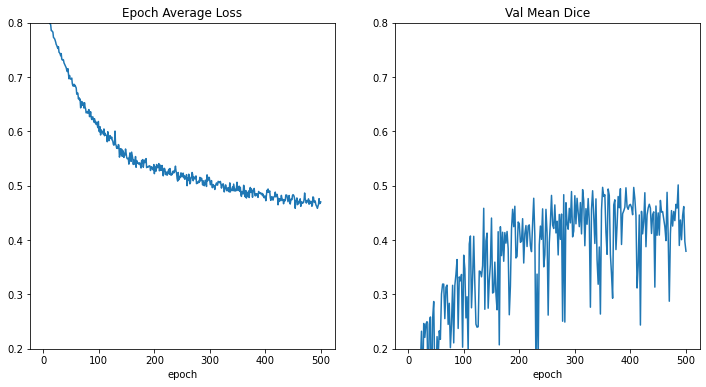

247ns_image_2734882394424_CLEAN.nii.gz


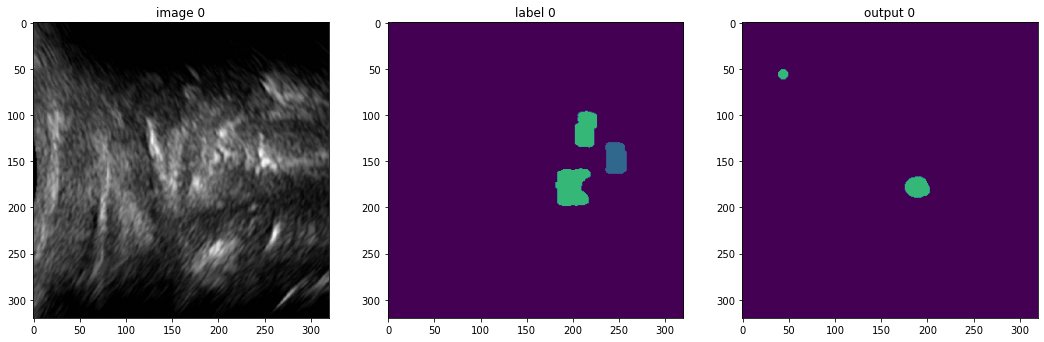

    ROI Number of not-sliding / sliding pixel = 0 0
    ROI Sldiing Min thresh = 1000
    ROI = Not Sliding
    Correct


  * Frame Winner = Not Sliding ( NS = 1 of 1 )
    Correct


247ns_image_2743083265515_CLEAN.nii.gz


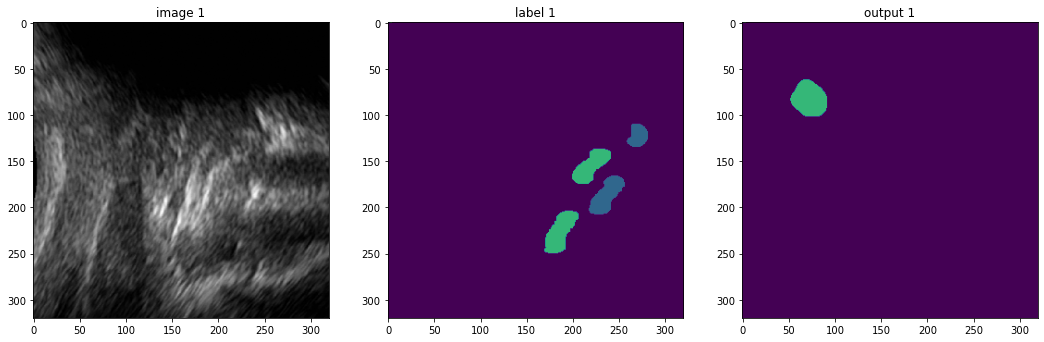

    ROI Number of not-sliding / sliding pixel = 0 0
    ROI Sldiing Min thresh = 1000
    ROI = Not Sliding
    Correct


  * Frame Winner = Not Sliding ( NS = 1 of 1 )
    Correct


 *** Patient Winner = Not Sliding ( NS = 2 of 2 )
     Correct


236s_iimage_1139765223418_CLEAN.nii.gz


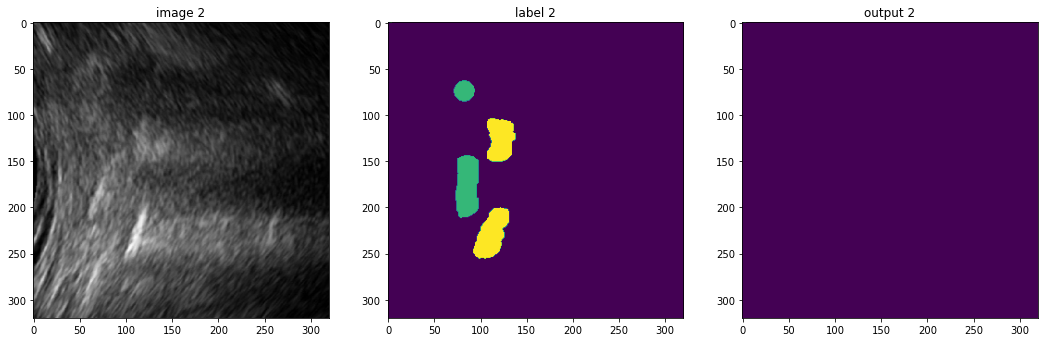

    ROI Number of not-sliding / sliding pixel = 0 0
    ROI Sldiing Min thresh = 1000
    ROI = Not Sliding
    Fales Positive


  * Frame Winner = Not Sliding ( NS = 1 of 1 )
    Frame FP = 236s_iimage_1139765223418_CLEAN.nii.gz


236s_iimage_1327616672148_clean.nii.gz


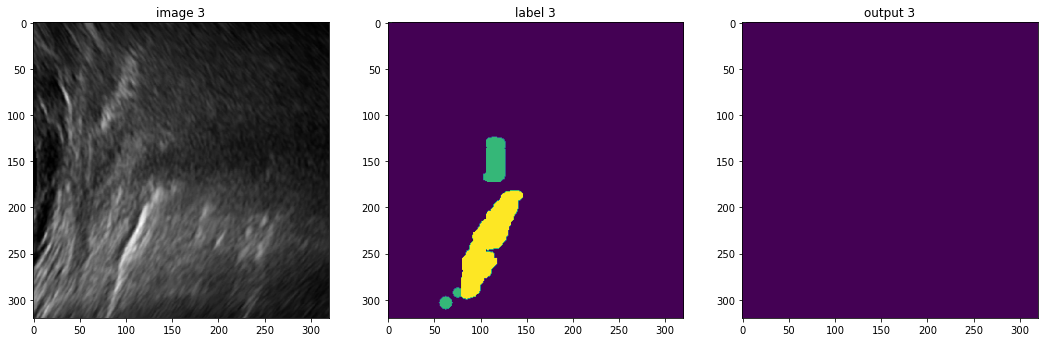

    ROI Number of not-sliding / sliding pixel = 0 0
    ROI Sldiing Min thresh = 1000
    ROI = Not Sliding
    Fales Positive


  * Frame Winner = Not Sliding ( NS = 1 of 1 )
    Frame FP = 236s_iimage_1327616672148_clean.nii.gz


 *** Patient Winner = Not Sliding ( NS = 4 of 4 )
     Patient FP = 236s_iimage_1327616672148_clean.nii.gz




KeyboardInterrupt: 

In [9]:
min_size_comp = 110000
max_size_comp = 160000

for sliding_prior in [1]:
    print('*************')
    print("Prior =", sliding_prior)
    t_p_correct = 0
    t_p_incorrect = 0
    t_p_false_negatives = 0
    t_f_correct = 0
    t_f_incorrect = 0
    t_f_false_negatives = 0
    t_r_correct = 0
    t_r_incorrect = 0
    t_r_false_negatives = 0
    for i in range(num_folds):
        (p_correct, p_incorrect, p_false_negatives, f_correct, f_incorrect, f_false_negatives, r_correct, r_incorrect, r_false_negatives) = plot_vfold_training_curves(
            i, test_loader[i], min_size_comp, max_size_comp, sliding_prior, True)
        t_p_correct += p_correct
        t_p_incorrect += p_incorrect
        t_p_false_negatives += p_false_negatives
        t_f_correct += f_correct
        t_f_incorrect += f_incorrect
        t_f_false_negatives += f_false_negatives
        t_r_correct += r_correct
        t_r_incorrect += r_incorrect
        t_r_false_negatives += r_false_negatives
    print()
    print()
    print("Patients: Correct =", t_p_correct, "Incorrect =", t_p_incorrect, "Not Sliding as Sliding =", t_p_false_negatives)
    print("Frame: Correct =", t_f_correct, "Incorrect =", t_f_incorrect, "Not Sliding as Sliding =", t_f_false_negatives)
    print("ROIs: Correct =", t_r_correct, "Incorrect =", t_r_incorrect, "Not Sliding as Sliding =", t_r_false_negatives)
    print('*************')


In [ ]:
import ipyparams
currentNotebook = ipyparams.notebook_name

from datetime import datetime
now = datetime.now()

experimentName = currentNotebook+now.strftime("-%Y.%m.%d_%H.%M.pdf")

cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)